In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [ ]:
# 一些超参数
learning_rate = 1e-3
eval_iters = 10
batch_size=1000
sequence_len=64
# 如果有GPU，该脚本将使用GPU进行计算
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
raw_datasets = load_dataset("Nan-Do/code-search-net-python")
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repo'])

In [ ]:
class CharTokenizer:

  def __init__(self, data, end_ind=0):
    super().__init__()
    self.end_ind = end_ind
    chars = sorted(list(set(''.join(data))))
    self.char2ind = {c : i + 1 for i, c in enumerate(chars)}
    self.char2ind['<|e|>'] = end_ind
    self.ind2char = {i : c for c, i in self.char2ind.items()}

  def encode(self, x):
    return [self.char2ind[i] for i in x]

  def decode(self, x):
    if isinstance(x, int):
      return self.ind2char[x]
    return [self.ind2char[i] for i in x]

tokenizer = CharTokenizer(datasets['original_string'])

In [ ]:
test_str = 'def f(x):'
re = tokenizer.encode(test_str)
print(re)
''.join(tokenizer.decode(range(len(tokenizer.char2ind))))

In [ ]:
def process(data, tokenizer, sequence_len=sequence_len):
  text = data['original_string']
  # text is list[str]
  inputs, labels = [], []
  for t in text:
    enc = tokenizer.encode(t)
    enc += [tokenizer.end_ind]
    for i in range(len(enc) - sequence_len):
      inputs.append(enc[i : i+sequence_len])
      labels.append(enc[i+1 : i+1+sequence_len])
  return {'inputs' : inputs, 'labels' : labels}

In [ ]:
# 将数据分为训练集和测试集
tokenized = datasets.train_test_split(test_size=0.1, seed=1024, shuffle=True)
f = lambda x : process(x, tokenizer)
tokenized = tokenized.map(f, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)

In [ ]:
tokenized

In [ ]:
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)
next(iter(train_loader))

In [ ]:
@torch.no_grad()
def generate(model, context, tokenizer, max_new_tokens=300):
  # context : (1, T)
  out = context.tolist()[0]
  model.eval()
  for _ in range(max_new_tokens):
    logits = model(context)   # (1, T, vs98)
    probs = F.softmax(logits[:, -1, :], dim=-1) # (1, vs98)
    # 随机生成文本
    ix = torch.multinomial(probs, num_samples=1) # (1, 1)
    # 更新背景
    context = torch.concat((context, ix), dim=-1)
    out.append(ix.item())
    if out[-1] == tokenizer.end_ind:
      break
  model.train()
  return out

In [ ]:
def estimate_loss(model):
  re = {}
  # 将模式切换至评估模式
  model.eval()
  re['train'] = _loss(model, train_loader)
  re['test'] = _loss(model, test_loader)
  # 将模型切换至训练模式
  model.train()
  return re


def _loss(model, data_loader):
  loss = []
  data_iter = iter(data_loader)

  # 随机使用多个批量数据来评估模型效果
  for k in range(eval_iters):
    data = next(data_iter)
    if data is None:
      data_iter = iter(data_loader)
      data = next(data_iter)
    inputs, labels = data['inputs'], data['labels'] # (B, T)
    logits = model(inputs) # (B, T, vs)
    loss.append(F.cross_entropy(logits.transpose(-2, -1), labels).item())
  return torch.tensor(loss).mean().item()

In [ ]:
def train_model(model, optimizer, epochs=10):
  lossi = []
  for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data['inputs'], data['labels'] # (B, T)
      logits = model(inputs) # (B, T, vs)
      optimizer.zero_grad()
      loss = F.cross_entropy(logits.transpose(-2, -1), labels)
      lossi.append(loss.item())
      loss.backward()
      optimizer.step()
    # 评估模型，并输出结果
    stats = estimate_loss(model)
    train_loss = f'train loss {stats["train"]:.4f}'
    test_loss = f'test loss {stats["test"]:.4f}'
    print(f'epoch {epoch:>2}: {train_loss}, {test_loss}')
  return lossi


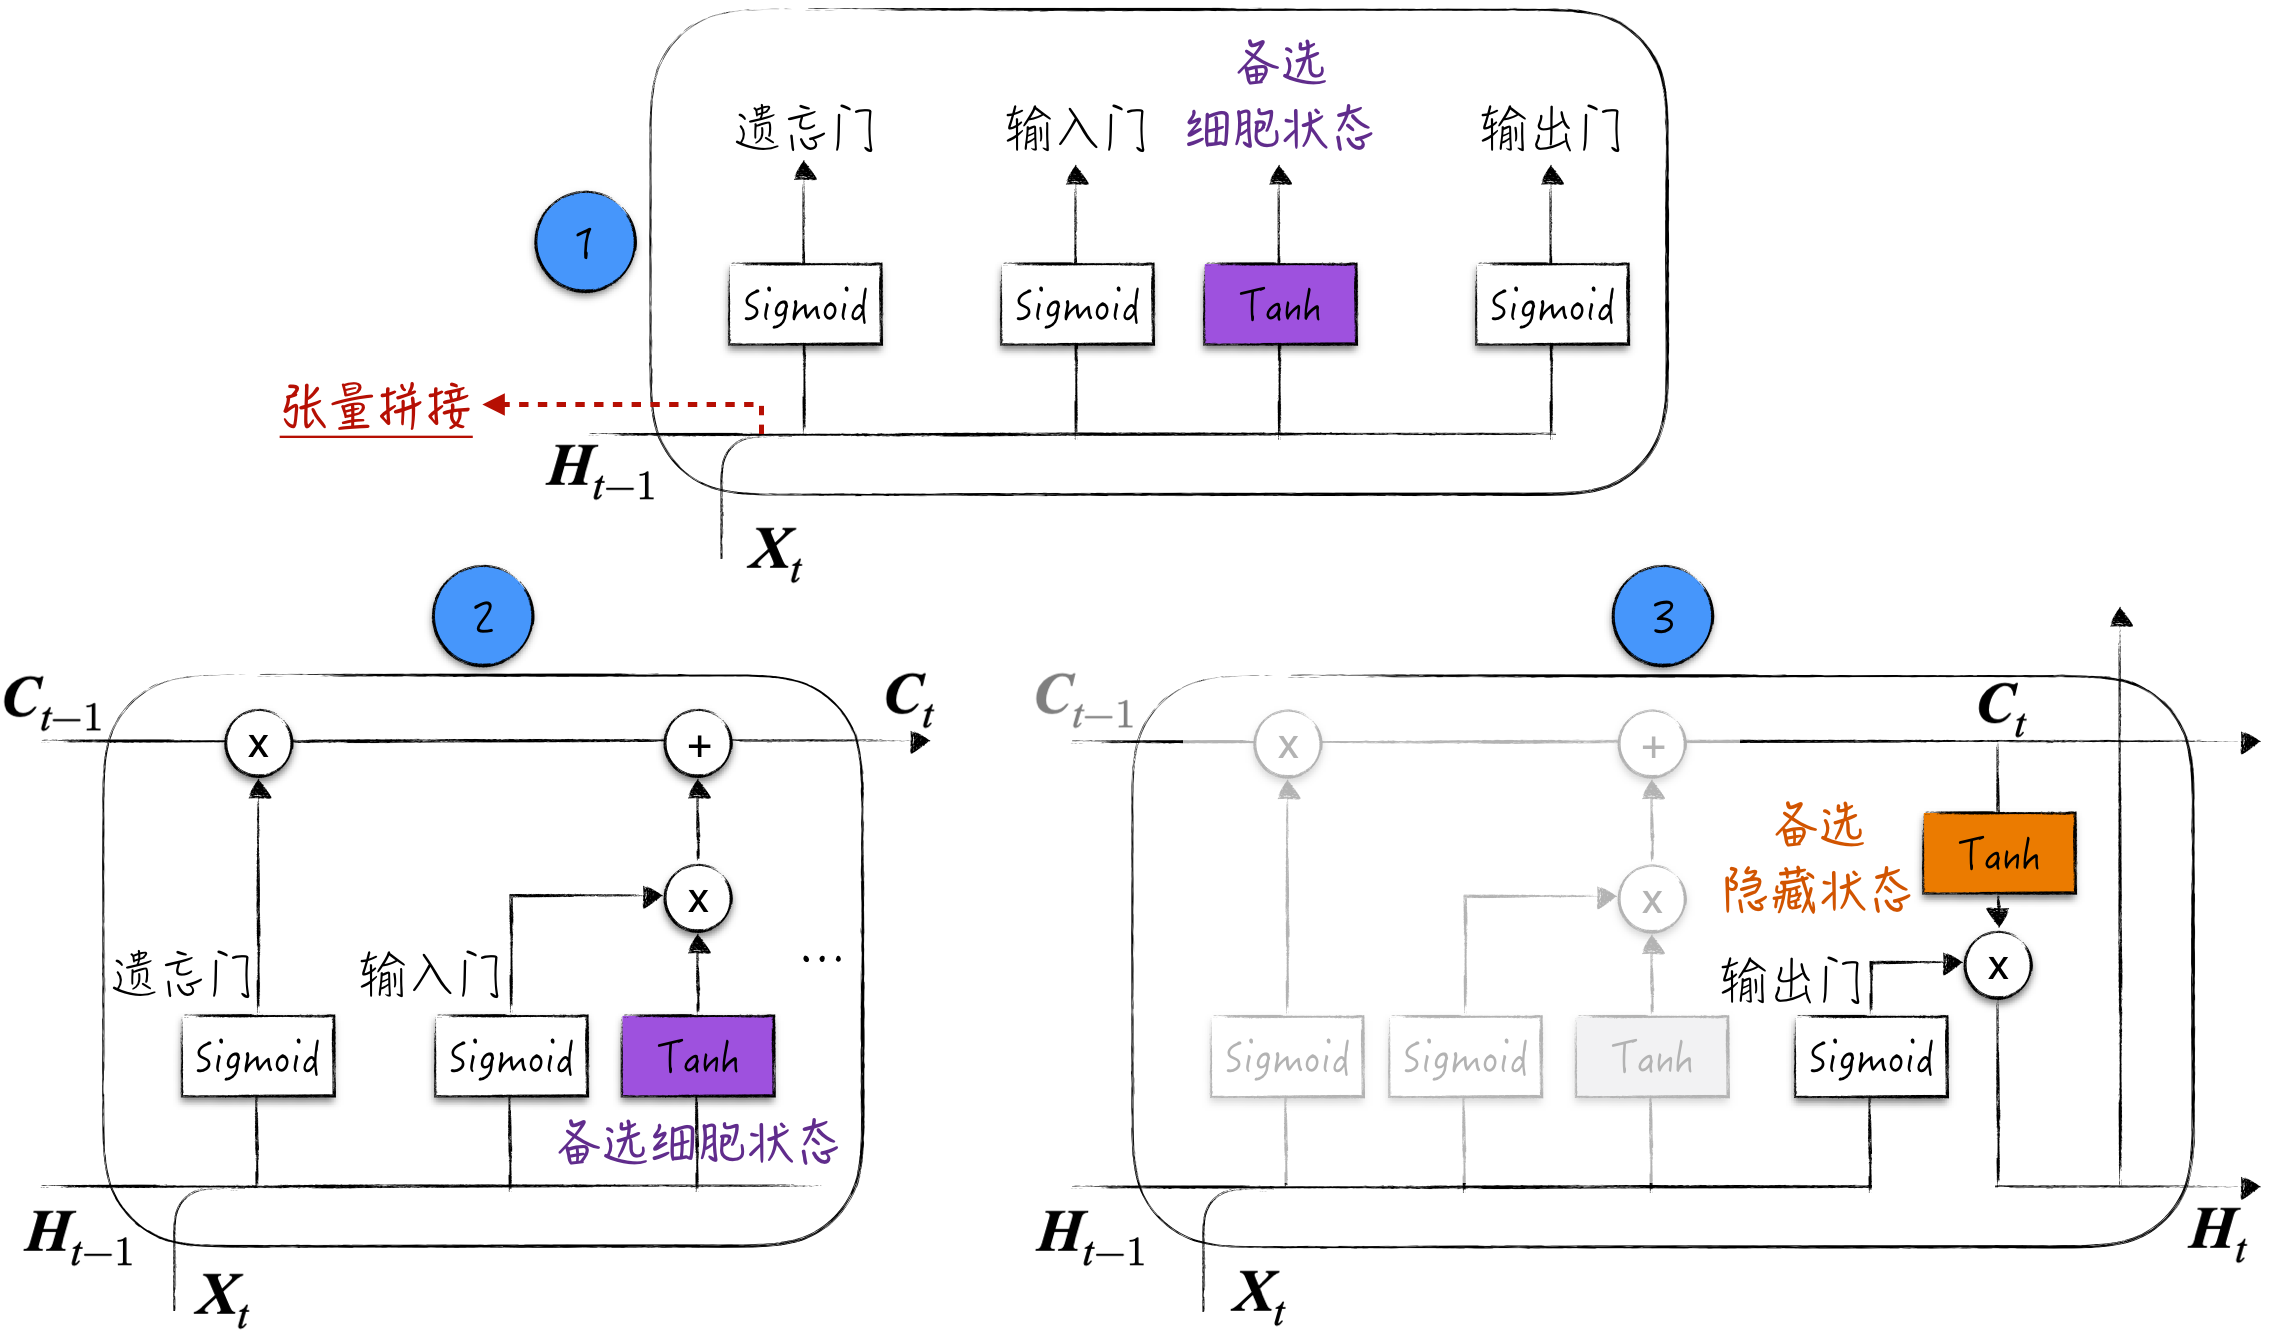

In [ ]:
class LSTMCell(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    combined_size = input_size + hidden_size
    self.forget_gate = nn.Linear(combined_size, hidden_size)  # 遗忘门
    self.in_gate = nn.Linear(combined_size, hidden_size)    # 输入门
    self.new_cell_state = nn.Linear(combined_size, hidden_size) # 备选细胞状态
    self.out_gate = nn.Linear(combined_size, hidden_size)   # 输出门

  def forward(self, input, state=None):
    # input: (B, I)
    # state: ((B, H), (B, H))
    B = input.shape[0]
    if state is None:
      state = self.init_state(B, input.device)
    hs, cs = state
    combined = torch.concat((input, hs), dim=-1) # (B, I+H)
    # 细胞状态的更新
    forgetgate = F.sigmoid(self.forget_gate(combined))
    ingate = F.sigmoid(self.in_gate(combined))
    ncs = F.tanh(self.new_cell_state(combined))
    cs = (cs * forgetgate) + (ingate * ncs)
    # 隐藏状态的更新
    outgate = F.sigmoid(self.out_gate(combined))
    hs =  F.tanh(cs) * outgate
    return hs, cs

  def init_state(self, B, device):
    hs = torch.zeros((B, self.hidden_size), device=device)
    cs = torch.zeros((B, self.hidden_size), device=device)
    return hs, cs



In [ ]:
l_cell = LSTMCell(3, 4)
x = torch.randn(5, 3)
a, b = l_cell(x)
a.shape, b.shape

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.cell = LSTMCell(input_size, hidden_size)

  def forward(self, input, state=None):
    # input:  (B, T, C)
    # state:  ((B, H), (B, H))
    # out:    (B, T, H)
    B, T, C = input.shape
    re = []
    for i in range(T):
      state = self.cell(input[:, i, :], state)
      re.append(state[0]) # hs
    return torch.stack(re, dim=1) # (B, T, H)

In [ ]:
def test_lstm():
    '''
    测试LSTM实现的准确性
    '''
    # 随机生成模型结构
    B, T, input_size, hidden_size, num_layers = torch.randint(1, 20, (5,)).tolist()
    ref_model = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
    # 随机生成输入
    inputs = torch.randn(B, T, input_size)
    hs, cs = torch.randn((2 * num_layers, B, hidden_size)).chunk(2, 0)
    re = inputs
    # 取出模型参数
    for layer_index in range(num_layers):
        l = ref_model.all_weights[layer_index]
        if layer_index == 0:
            model = LSTM(input_size, hidden_size)
        else:
            model = LSTM(hidden_size, hidden_size)
        i, f, c, o = torch.cat((l[0], l[1]), dim=1).chunk(4, 0)
        ib, fb, cb, ob = (l[2] + l[3]).chunk(4, 0)
        # 设置模型参数
        model.cell.in_gate.weight = nn.Parameter(i)
        model.cell.in_gate.bias = nn.Parameter(ib)
        model.cell.forget_gate.weight = nn.Parameter(f)
        model.cell.forget_gate.bias = nn.Parameter(fb)
        model.cell.new_cell_state.weight = nn.Parameter(c)
        model.cell.new_cell_state.bias = nn.Parameter(cb)
        model.cell.out_gate.weight = nn.Parameter(o)
        model.cell.out_gate.bias = nn.Parameter(ob)
        # 计算隐藏状态
        re = model(re, (hs[layer_index], cs[layer_index]))
    ref_re, _ = ref_model(inputs, (hs, cs))
    # 验证计算结果（最后一层的隐藏状态是否一致）
    out = torch.all(torch.abs(re - ref_re) < 1e-4)
    return out, (B, T, input_size, hidden_size, num_layers)

test_lstm()

In [ ]:
class CharLSTM(nn.Module):

  def __init__(self, vs):
    super().__init__()
    self.emb_size = 256
    self.hidden_size = 128
    self.emb = nn.Embedding(vs, self.emb_size)
    self.dp = nn.Dropout(0.4)
    self.lstm1 = LSTM(self.emb_size, self.hidden_size)
    self.ln1 = nn.LayerNorm(self.hidden_size)
    self.lstm2 = LSTM(self.hidden_size, self.hidden_size)
    self.ln2 = nn.LayerNorm(self.hidden_size)
    self.lstm3 = LSTM(self.hidden_size, self.hidden_size)
    self.ln3 = nn.LayerNorm(self.hidden_size)
    self.lm = nn.Linear(self.hidden_size, vs)

  def forward(self, x):
    # x: (B, T)
    embeddings = self.emb(x)   # (B, T, C)
    h = self.ln1(self.dp(self.lstm1(embeddings)))  # (B, T, H)
    h = self.ln2(self.dp(self.lstm2(h)))           # (B, T, H)
    h = self.ln3(self.dp(self.lstm3(h)))           # (B, T, H)
    output = self.lm(h)
    return output

In [ ]:
c_model = CharLSTM(len(tokenizer.char2ind)).to(device)
c_model

In [ ]:
context = torch.tensor(tokenizer.encode('def'), device=device).unsqueeze(0)
print(''.join(tokenizer.decode(generate(c_model, context, tokenizer))))

In [ ]:
estimate_loss(c_model)

In [ ]:
l = train_model(c_model, optim.Adam(c_model.parameters(), lr=learning_rate))

In [ ]:
context = torch.tensor(tokenizer.encode('def'), device=device).unsqueeze(0)
print(''.join(tokenizer.decode(generate(c_model, context, tokenizer))))